In [1]:
import numpy as np

import hubbardml
from hubbardml import keys
from hubbardml import utils

In [2]:
SAVEFIGS = True

# Project

Load the project to be used

In [3]:
PROJECT_PATH = '../V-2022.10.25-2105'
project = hubbardml.Project(PROJECT_PATH)
project.to('cpu')

if isinstance(project.model, hubbardml.models.UModel):
    PARAM_TYPE = 'U'
elif isinstance(project.model, hubbardml.models.VModel):
    PARAM_TYPE = 'V'
elif isinstance(project.model, hubbardml.models.UVModel):
    PARAM_TYPE = 'UV'
else:
    raise ValueError(f'Unknown model type: {project.model.__class__.__name__}')

trainer = project.trainer
model = project.model

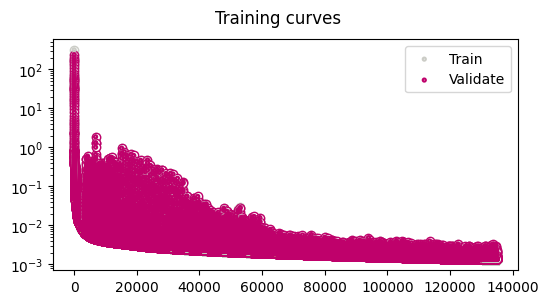

In [4]:
trainer.plot_training_curves();

In [5]:
df = project.infer()

# Get the indices of the training and test data
train_idx = df[df[keys.TRAINING_LABEL] == keys.TRAIN].index
validate_idx = df[df[keys.TRAINING_LABEL] == keys.VALIDATE].index

In [6]:
df_validate = df.loc[validate_idx]
test_rmse = hubbardml.datasets.rmse(df)

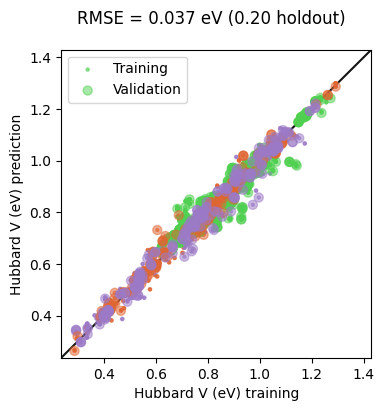

In [7]:
hubbardml.plots.create_parity_plot(
    df,
    axis_label=f'Hubbard {PARAM_TYPE} (eV)',
    title=f'RMSE = {test_rmse:.3f} eV ({project.validate_percentage:.2f} holdout)'
);

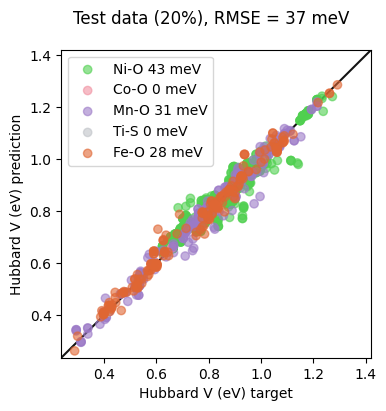

In [8]:
fig = hubbardml.plots.split_plot(
    df_validate,
    keys.LABEL,
    axis_label=f'Hubbard {PARAM_TYPE} (eV)',
    title=f'Test data ({project.validate_percentage * 100:.0f}%), RMSE = {utils.to_mev_string(test_rmse)}'
);
if SAVEFIGS:
    fig.savefig(f'plots/{PARAM_TYPE}_parity_species.pdf', bbox_inches='tight')

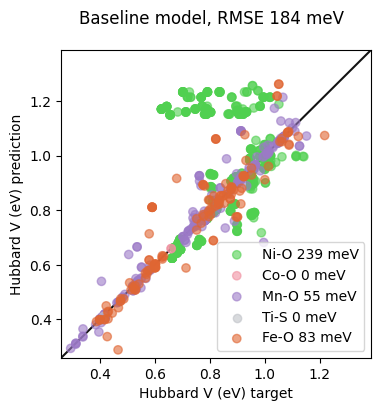

In [9]:
df_ref = df_validate.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = hubbardml.plots.split_plot(
    df_ref,
    keys.LABEL,
    axis_label=f'Hubbard {PARAM_TYPE} (eV)',
    title=f'Baseline model, RMSE {utils.to_mev_string(hubbardml.datasets.rmse(df_ref))}'
);
if SAVEFIGS:
    fig.savefig(f'plots/{PARAM_TYPE}_parity_species_ref.pdf', bbox_inches='tight')

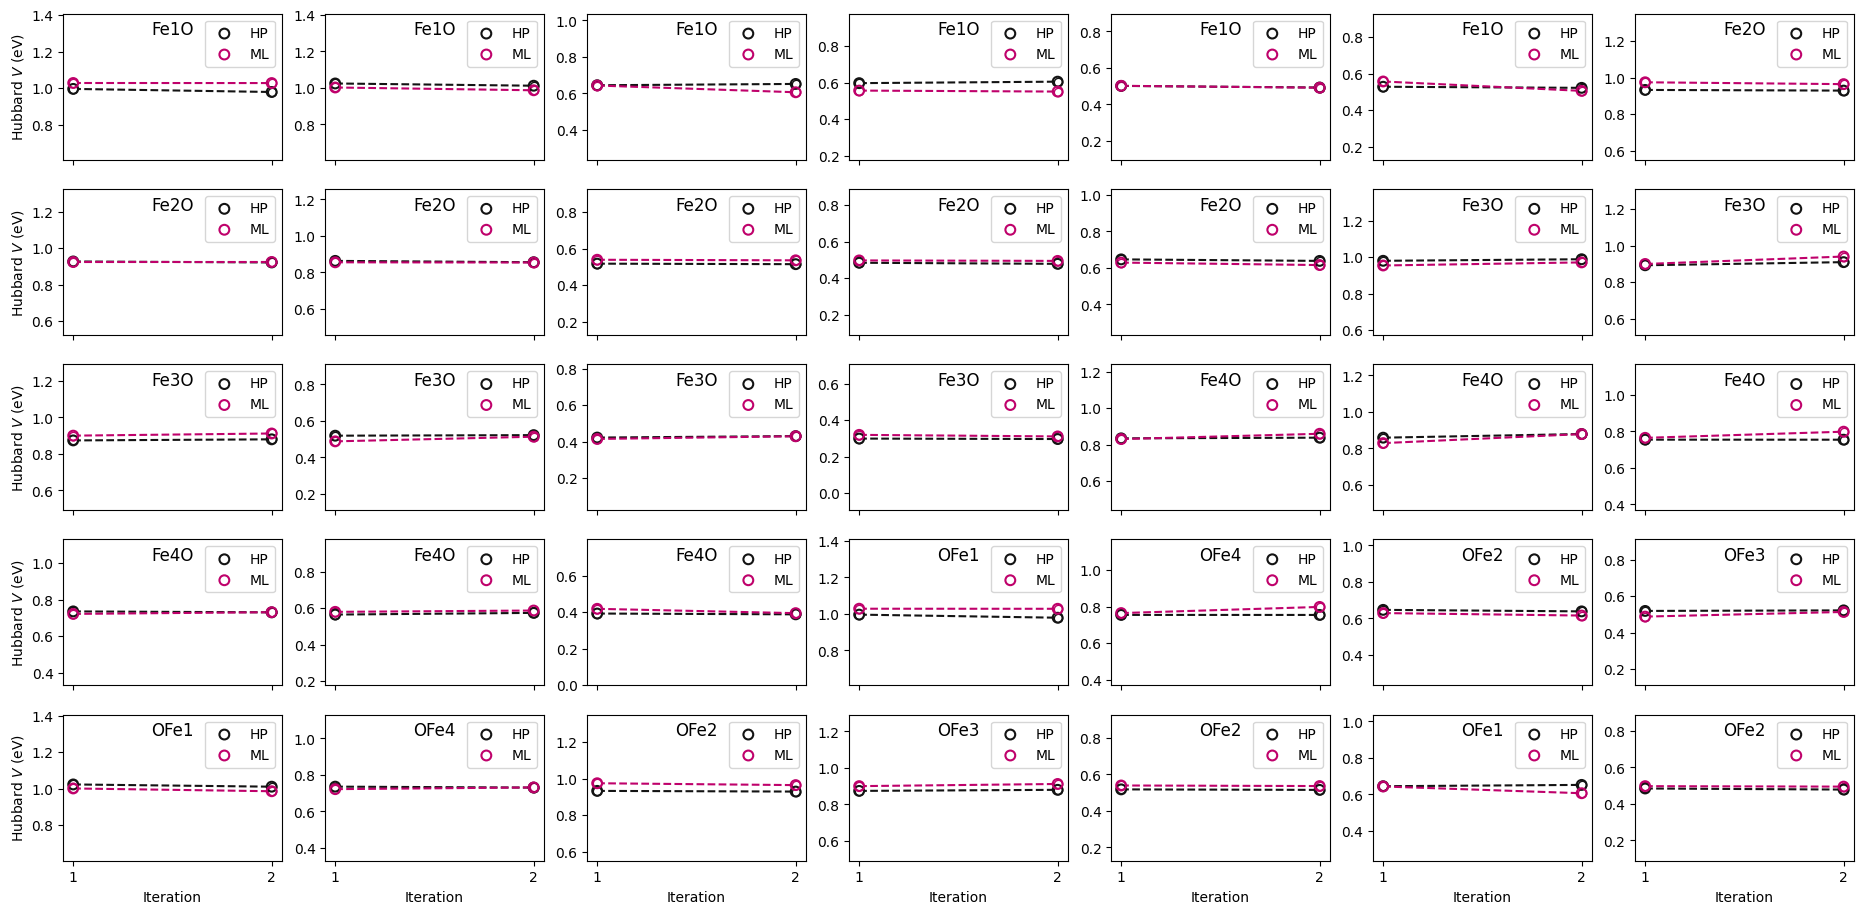

In [10]:
NUM_COLS = 7
NUM_ROWS = 5

fig = hubbardml.plots.create_progression_plots(
    df,
    yrange=0.8,
    num_cols=NUM_COLS,
    max_plots=NUM_COLS * NUM_ROWS,
    scale=0.55,
);

if SAVEFIGS:
    fig.savefig(f'plots/{PARAM_TYPE}_convergence.pdf', bbox_inches='tight')

In [11]:
print(len(df))
print(df.loc[train_idx]['species'].apply(tuple).value_counts())
print(df.loc[validate_idx]['species'].apply(tuple).value_counts())

4512
(Ni, O)    1845
(O, Mn)     995
(Fe, O)     749
(Co, O)      14
(Ti, S)       6
Name: species, dtype: int64
(Ni, O)    461
(O, Mn)    249
(Fe, O)    187
(Co, O)      4
(Ti, S)      2
Name: species, dtype: int64


In [19]:
def histogram_plot(df):
    for label in df[keys.LABEL].unique():
        frame = df[df[keys.LABEL] == label]
        series = frame[keys.PARAM_OUT_PREDICTED] - frame[keys.PARAM_OUT]
        ax = series.plot.hist(
            alpha=0.6,
            label=label,
            color=frame.iloc[0][keys.COLOUR],
            density=True,
            # histtype='step',
            xlabel="Energy difference (eV)",
            bins=50,
            range=(-0.4, 0.4),
            figsize=(3, 4),
        )
    ax.set_xlabel("Energy difference (eV)")
    ax.set_ylim((0, 50))
    ax.legend()
    return ax

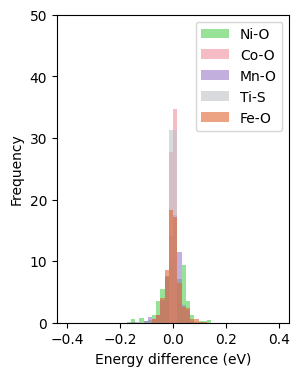

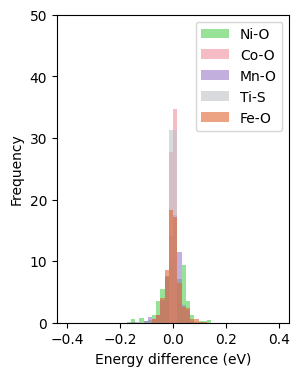

In [20]:
ax = histogram_plot(df)

ax.get_figure()

<AxesSubplot: xlabel='Energy difference (eV)', ylabel='Frequency'>

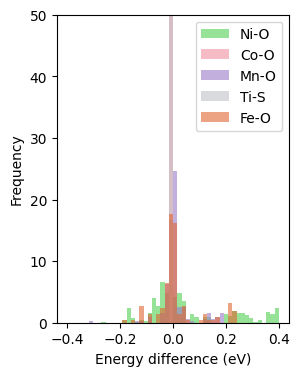

In [21]:
histogram_plot(df_ref)

In [22]:
last_step_df = df.copy()
for path in hubbardml.datasets.get_self_consistent_paths(last_step_df):
    frame = last_step_df[last_step_df[keys.DIR].str.contains(path)]

    pairs = frame.apply(lambda row: (row[keys.ATOM_1_IDX], row[keys.ATOM_2_IDX]), axis=1)
    unique_pairs = pairs.unique()

    for pair in unique_pairs:
        pair_rows = frame[frame.index.isin(pairs[pairs == pair].index)]
        sorted_df = pair_rows.sort_values(by=[keys.UV_ITER])
        iters = sorted_df[keys.UV_ITER]
        row = sorted_df.iloc[0]

        non_first = pair_rows[pair_rows[keys.UV_ITER] != row[keys.UV_ITER]]
        last_step_df.loc[last_step_df.index.isin(non_first.index), keys.PARAM_OUT] = row[keys.PARAM_OUT]

<AxesSubplot: xlabel='Energy difference (eV)', ylabel='Frequency'>

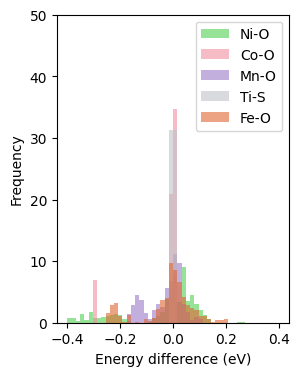

In [23]:
histogram_plot(last_step_df)
